# 2ª Lista de Exercícios - Deep Learning

Universidade Federal da Paraíba - Centro de Informática

Programa de Pós-Graduação em Informática (PPGI)

Nome: Thiago Viana de Carvalho

Semestre: 2018.1

## Parte 1 - Redes Neurais e Imagens

Em um problema real de Redes Neurais, normalmente uma instância pode possuir inúmeras entradas, resultando em uma arquitetura de rede extensa com muitos neurônios e de múltiplas camadas.

Um exemplo comum de aplicação nesse escopo é um classificador de imagens, em que cada entrada representa um neurônio da camada de entrada. Sabendo disso, esse notebook tem como objetivo implementar uma Rede Neural Multicamada (MLP) para o dataset MNIST. O MNIST é um dataset de dígitos escritos a mão, conforme Figura 1.

A MLP deve ser implementada de forma a utilizar uma arquitetura simples e ainda, assim, obter uma performance elevada. Ao final, três modelos de rede devem ser implementados e comparados. Os detalhes de implementação devem ser justificados a cada questão e será dividido em 5 etapas:

    - Leitura, visualização e pré-processamento do dataset [ok]
    - Conversão do array de predições Y [ok]
    - Definição da topologia da rede (camadas e neurônios) [ok]
    - Definir otimizador, função custo e modo do treinamento (batch, mini-batch, estocástico) [ok]
    - Treinamento e avaliação de resultados [colocar gráficos e matriz de confusão]
    
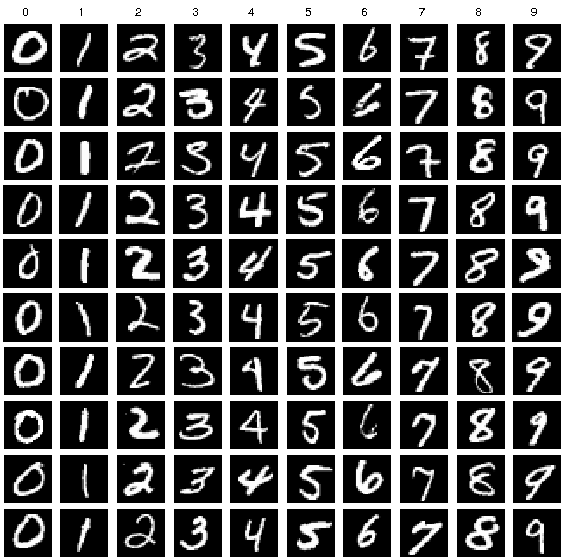

### Importações utilizadas

In [23]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

### Leitura, visualização e pré-processamento do dataset

Para este exercício, foi utilizado o Keras, uma API de alto nível para Redes Neurais que facilita a prototipação e dá suporte aos mais variados tipos de rede, como redes convolucionais e redes recorrentes. O Keras possui um conjunto de datasets, incluindo o MNIST, facilitando a leitura e o carregamento dos dados do MNIST. Após a leitura do dataset, precisa-se descobrir as dimensões da imagem, o número de instâncias, classes e entrada.

Quanto ao pré-processamento do dataset, como uma imagem é uma matriz de pixels, para que possamos colocar esses dados em um Perceptron de Múltiplas Camadas, transformamos essa matriz em um vetor, no caso, um vetor de tamanho 784 para cada imagem, tendo em vista que as imagens do MNIST tem tamanho 28x28. Também devemos converter a imagem para tons de cinza.

Sabendo que cada pixel da imagem guarda um valor de 0 (preto) a 255 (branco), normalizamos as imagens dividindo-as por 255, para que os valores fiquem entre 0 e 1.

Amostras de treinamento: 60000
Amostras de teste: 10000
Dimensões: 28x28
[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


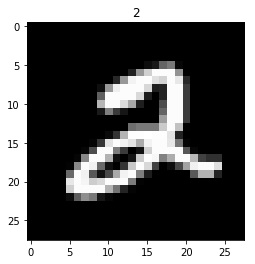

In [24]:
### seed
seed = 3
np.random.seed(seed)

### carrega os dados do dataset (leitura)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Visualizar instâncias
plt.imshow(x_train[5], cmap=plt.get_cmap('gray'))
plt.title(y_train[5])
### Print - informações das instâncias
print("Amostras de treinamento: " + str(x_train.shape[0]))
print("Amostras de teste: " + str(x_test.shape[0]))
print("Dimensões: " + str(x_train.shape[1]) + "x" + str(x_train.shape[2]))

### Pré-processamento do dataset
## transformando as imagens 28*28 para um vetor de tamanho 784 para cada imagem
n_pixels = x_train.shape[1] * x_train.shape[2]       #largura * altura
x_train = x_train.reshape(x_train.shape[0], n_pixels).astype('float32')
x_test =  x_test.reshape(x_test.shape[0], n_pixels).astype('float32')

## normalizando as entradas de 0-255 para 0-1
x_train = x_train / 255
x_test = x_test / 255
print(y_train)
print(y_test)

### Conversão do array de predições Y

O método abaixo representa a saída como one-hot encoding. One-hot encoding é um processo que converte variáveis que categorizam os rótulos (ou valores categóricos) de uma determinada base de dados, de foma que os algoritmos de Machine Learning possam fazer um melhor trabalho de predição.

A codificação por rótulo tem como problema o fato de que ele pressupõe que quanto maior o valor categórico de uma entrada, melhor a categoria. Além disso, se basear apenas nos valores categóricos das entradas pode levar a um conjunto de erros nas predições dos modelos devido a cálculos incorretos. Por essa razão, o one-hot encoding se mostra altamente importante para "binarizar" cada categoria e incluí-la como um aspecto ou traço (feature) utilizado para treinar o modelo.

Ex.: suponha que você tenha um traço 'flower', que tem valores categóricos 'daffodil', 'rose' e 'lily'. O uso do one-hot encoding converte o traço 'flower' em três traços binários ('is_daffodil', 'is_lily', 'is_rose').

Fonte: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [25]:
def one_hot(true_labels):
    """
    Função que implementa o one-hot encoding
    Entrada: true_labels - array original com os labels
    Retorna: labels - conversão one-hot          
    """
    labels = keras.utils.to_categorical(true_labels)
    
    return labels

In [44]:
#testando o método
num_cl = one_hot(y_train)
print(y_train[:6])
print(num_cl[:6])
print(num_cl.shape[1])

[5 0 4 1 9 2]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
10


### Definição de Topologia da Rede

Mostre as três arquiteturas que serão utilizadas para resolver o problema. As arquiteturas devem ser simples de forma a retornar bons resultados com a menor quantidade necessária de neurônios e camadas. As três arquiteturas devem variar apenas quanto ao número de neurônios e camadas (incluindo regularização). Baseado nisso, explique:

    - Quantos neurônios serão utilizados em cada camada?
    - Quantas camadas serão utilizadas?
    - É necessário utilizar regularização? Se sim explique a técnica que foi utilizada e o impacto nos resultados
    - Qual função de ativação será utilizada? Escolha duas funções de ativação e explique os resultados obtidos
    
### Definição do otimizador, função de custo e modo do treinamento

Uma Rede Neural é um problema de otimização, sabendo disso, explique:

    - Qual otimizador será utilizado? Escolha dois otimizadores, explique a diferença entre eles justificando a escolha e comente os resultados obtidos.
    - Será necessário utilizar uma função custo? Explique o que é uma função custo e qual será utilizada justificando a escolha.
    - Qual modo de treinamento foi utilizado? Justifique sua resposta
    - Quantas épocas serão necessárias? Caso os métodos por batch ou mini-batch sejam escolhidos, indique também o tamanho

### Otimizadores utilizados

Para as três arquiteturas criadas abaixo, foram selecionados para os testes os otimizadores 'Adam (Adaptive Moment Estimation)' e 'SGD (Stochastic Gradient Descent) com momento de Nesterov'. O SGD é um algoritmo de otimização mais popular não só para Deep Learning, mas para Machine Learning de uma maneira geral, além de ser ótimo para um grande conjunto de dados de treinamento. O uso do momento de Nesterov é voltado para acelerar o aprendizado da rede, buscando o mínimo global de uma forma mais rápida.

Com relação ao Adam, o que o diferencia do SGD é o fato de ser um otimizador com taxa de aprendizado adaptativa, que realiza uma descida de gradiente, mas aplicando médias móveis com o passo anterior e com a derivada obtida pela retropropagação. Além de ser computacionalmente eficiente, os requisitos de memória são mínimos, são invariantes ao redimensionamento diagonal dos gradientes, e se mostram adequados para problemas com grandes conjuntos de dados/parâmetros ou problemas com gradientes esparsos e/ou com muito ruído. A figura abaixo mostra a performance de vários algoritmos de otimização para o problema do MNIST.

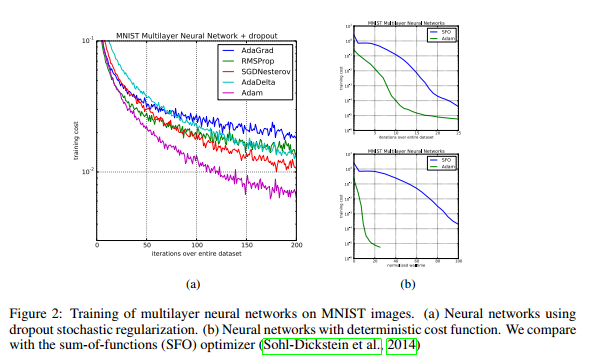
Fonte: (KINGMA & BA, 2015)

### Função de custo

Uma função de custo avalia as saídas da rede e compara com as saídas esperadas, isto é, calcula o erro cometido pela rede neural, para que, com base nesse erro, seja feito o ajuste dos pesos até que a rede consiga aprender com os exemplos. Tendo em vista que se trata de um problema de classificação de múltiplas classes (no caso do MNIST, temos 10 classes), a função escolhida para este problema foi a 'categorical_crossentropy', já que este é mais adequado a exemplos cujas classes são mutuamente exclusivas, isto é, um exemplo de treinamento pertencerá a uma única classe.

### Modo de treinamento
Para o treinamento das redes, foi utilizado o modo de treinamento por lote, com o batch size de 256.

### Treinamento e avaliação dos resultados

Treine as três redes e mostre os resultados de cada uma a partir das questões anteriores.

#### Arquitetura 1 (Topologia)

    - Número de camadas: 4
    - Neurônios: [28, 25, 25, 10]
    - Regularização: L2 (lambda = 0.001) + dropout (0.1)
    - Funções de ativação utilizadas: Relu (camadas ocultas), Softmax (camada de saída)
    - Épocas: 20
    
    
    - Otimizador: 'adam' e 'SGD (nesterov)'
    - Função de custo: 'categorical_crossentropy'
    - Modo de treinamento: lote (batch = 256)
    
Com relação à regularização, foram realizados testes com a rede utilizando as técnicas de regularização L2 e L1, bem como a rede sem regularização, onde após a análise dos resultados, foi percebido que para esta arquitetura, a regularização L2 (lambda = 0.001) apresentou resultados levemente melhores, se comparados com redes sem regularização. Segue abaixo uma tabela comparativa:

#### Otimizador ADAM
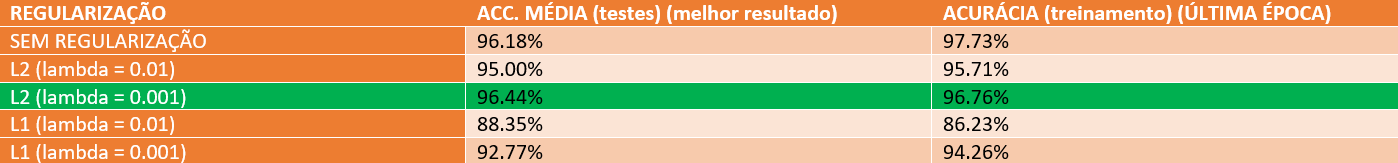

#### Otimizador SGD (Nesterov)
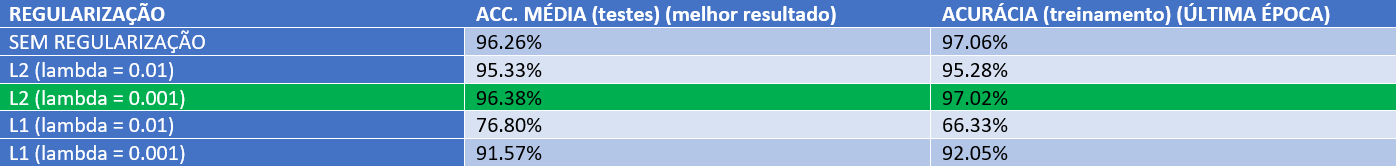

In [55]:
### Arquitetura da rede
arch1_model = Sequential()
## camadas
arch1_model.add(Dense(28,input_dim=784, kernel_regularizer=keras.regularizers.l2(0.001)))
arch1_model.add(Dropout(0.1))
arch1_model.add(Dense(25, activation='relu'))
arch1_model.add(Dense(25, activation='relu'))
arch1_model.add(Dense(10, activation='softmax'))

arch1_model.summary()

## problema de classificação multi-classe
### optimizer='adam'
### optimizer=keras.optimizers.SGD(lr=0.03, momentum=0.80, decay=0.0, nesterov=True)
arch1_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = arch1_model.fit(x_train, one_hot(y_train), epochs=20, batch_size=256, validation_data=(x_test, one_hot(y_test)))

scores = arch1_model.evaluate(x_test, one_hot(y_test))
print("Test %s: %.2f%%" % (arch1_model.metrics_names[1], scores[1]*100))
print("Test loss: %.4f" % (scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 28)                21980     
_________________________________________________________________
dropout_10 (Dropout)         (None, 28)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 25)                725       
_________________________________________________________________
dense_74 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_75 (Dense)             (None, 10)                260       
Total params: 23,615
Trainable params: 23,615
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.7660 - 

Text(0.5,0,'epoch')

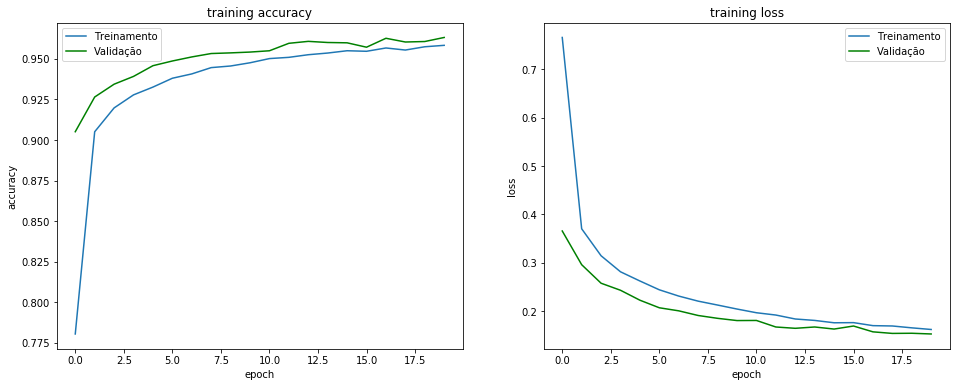

In [56]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
plt.title('training loss')
plt.ylabel('loss')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.xlabel('epoch')

#### Arquitetura 2 (Topologia)

    - Número de camadas: 3
    - Neurônios: [50, 50, 10]
    - Regularização: sem regularização
    - Funções de ativação utilizadas: [...,relu,softmax]
    - Épocas: 20
    
    - Otimizador: 'adam' e 'SGD (nesterov)'
    - Função de custo: 'categorical_crossentropy'
    - Modo de treinamento: lote (batch = 64)
    
#### Testes
#### Otimizador ADAM
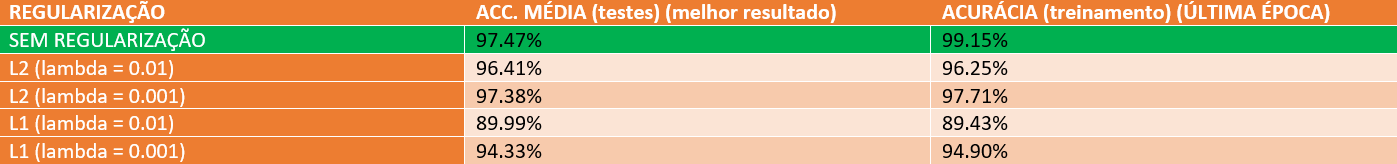

#### Otimizador SGD (Nesterov)
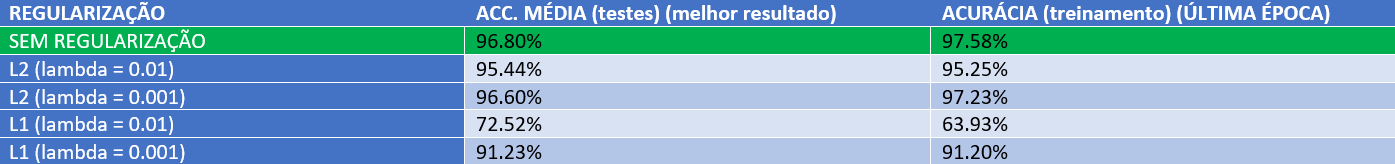

In [51]:
### kernel_regularizer=keras.regularizers.l2(0.001)
### activity_regularizer=keras.regularizers.l1(0.001)

### Arquitetura da rede
arch2_model = Sequential()
## camadas
arch2_model.add(Dense(50,input_dim=784))
arch2_model.add(Dense(50, activation='relu'))
arch2_model.add(Dense(10, activation='softmax'))
arch2_model.summary()

## problema de classificação multi-classe
### optimizer='adam'
### optimizer=keras.optimizers.SGD(lr=0.03, momentum=0.80, decay=0.0, nesterov=True)
arch2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = arch2_model.fit(x_train, one_hot(y_train), epochs=20, batch_size=256, validation_data=(x_test, one_hot(y_test)))

scores = arch2_model.evaluate(x_test, one_hot(y_test))
print("Test %s: %.2f%%" % (arch2_model.metrics_names[1], scores[1]*100))
print("Test loss: %.4f" % (scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_66 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_67 (Dense)             (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.5207 - acc: 0.8560 - val_loss: 0.2622 - val_acc: 0.9228
Epoch 2/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.2326 - acc: 0.9332 - val_loss: 0.2033 - val_acc: 0.9420
Epoch 3/20
60000/60000 [==============================] - 1s 12us/step - loss:

Text(0.5,0,'epoch')

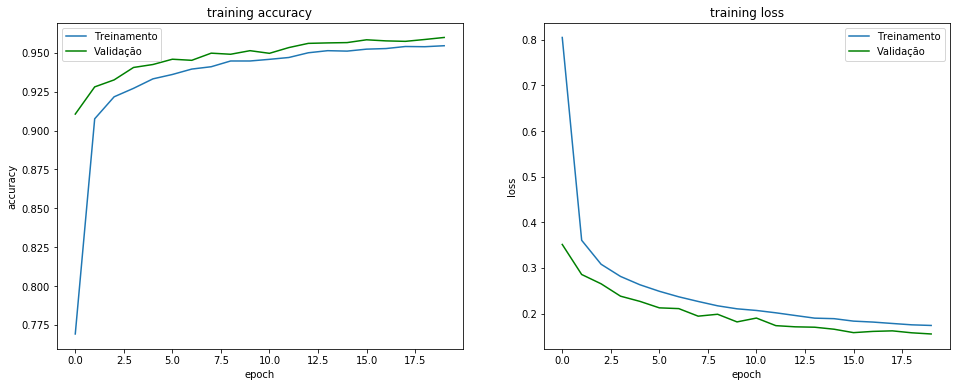

In [52]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
plt.title('training loss')
plt.ylabel('loss')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.xlabel('epoch')

#### Arquitetura 3

    - Número de camadas: 4
    - Neurônios: [32, 64, 64, 10]
    - Regularização: L2 (otimizador Adam) ou sem regularização (otimizador SGD (nesterov))
    - Funções de ativação utilizadas: [...,relu, relu, softmax]
    
    - Otimizador: 'adam' e 'SGD (nesterov)'
    - Função de custo: 'categorical_crossentropy'
    - Modo de treinamento: lote (batch = 256)
    
#### Testes
#### Otimizador ADAM
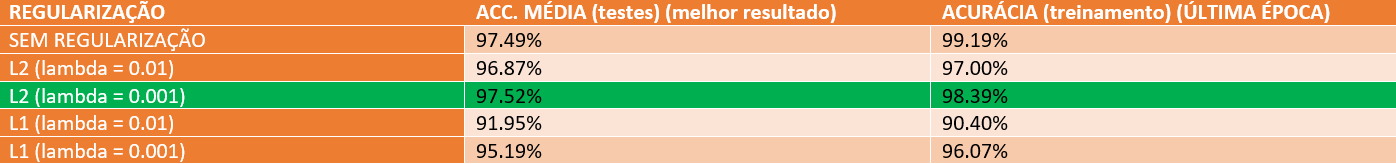
#### Otimizador SGD (Nesterov)
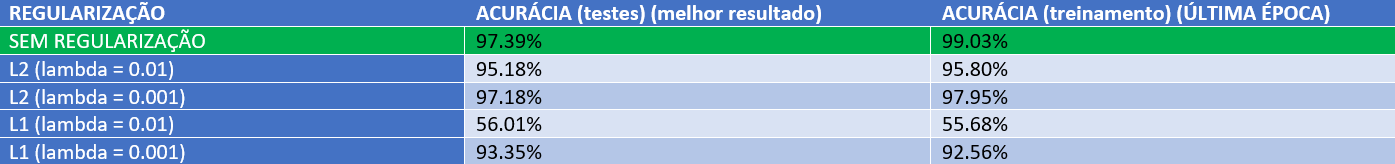

In [57]:
### kernel_regularizer=keras.regularizers.l2(0.001)
### activity_regularizer=keras.regularizers.l1(0.001)

### Arquitetura da rede
arch3_model = Sequential()
## camadas
arch3_model.add(Dense(32,input_dim=784, kernel_regularizer=keras.regularizers.l2(0.001)))
arch3_model.add(Dense(64, activation='relu'))
arch3_model.add(Dense(64, activation='relu'))
arch3_model.add(Dense(10, activation='softmax'))
arch3_model.summary()

## problema de classificação multi-classe
### optimizer='adam'
### optimizer=keras.optimizers.SGD(lr=0.03, momentum=0.80, decay=0.0, nesterov=True)
arch3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = arch3_model.fit(x_train, one_hot(y_train), epochs=20, batch_size=256, validation_data=(x_test, one_hot(y_test)))

scores = arch3_model.evaluate(x_test, one_hot(y_test))
print("Test %s: %.2f%%" % (arch3_model.metrics_names[1], scores[1]*100))
print("Test loss: %.4f" % (scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_78 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_79 (Dense)             (None, 10)                650       
Total params: 32,042
Trainable params: 32,042
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.6097 - acc: 0.8333 - val_loss: 0.3225 - val_acc: 0.9155
Epoch 2/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.28

Text(0.5,0,'epoch')

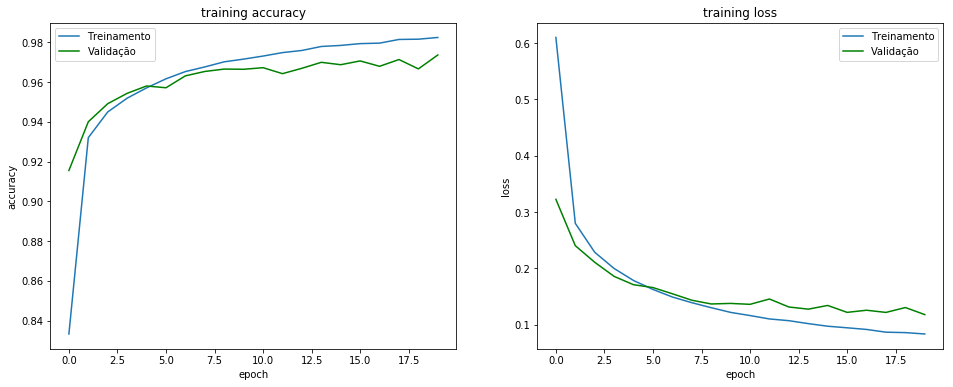

In [58]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], color='green')
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
plt.title('training loss')
plt.ylabel('loss')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.xlabel('epoch')